# General ApRES Processing Procedure

Starting from chirps going to velocity. The goal of this notebook is to walk through the processing steps one step at a time to help use better understand where and how bad data could impact our calculations.

In [1]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    14:48:12 	 ApRESDefs.py @function _setup_logging line 495 - Stream logging level set to DEBUG
DEBUG    14:48:12 	 ApRESDefs.py @function _setup_logging line 496 - Add console handler to logger
DEBUG    14:48:12 	 ApRESDefs.py @function _setup_logging line 509 - File logging level set to DEBUG


In [3]:
# Loading site data - we use station 101 for now
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")

In [4]:
# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41179")
client

<Client: 'tcp://127.0.0.1:41179' processes=4 threads=16, memory=58.87 GiB>

## Part 1: Describing processing steps to get a profile

Let's select an arbitrary series of 100 bursts (of 20 stacked chirps) to make sure that we can find a good burst/chirp to work with as an example

In [5]:
timeseries = ds_101.isel(attenuator_setting_pair = 0,time=range(1000,1100)).compute()


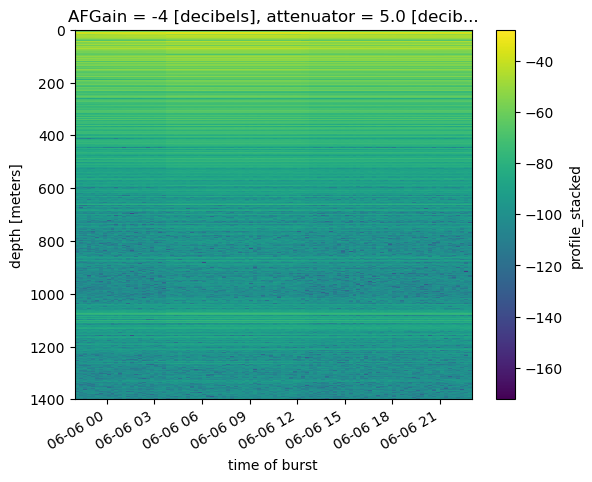

In [6]:
xa.dB(timeseries.profile_stacked).plot(x='time')
plt.gca().invert_yaxis()

t=1000 looks pretty valid. There seems to be clearly defined reflectors and the subsequent bursts look similar. Now, let's look at the processing since the start of this range. We start by plotting the chirp itself. This is the rawest form of the data that we'll be working with. Looking at this chirp, we see the start of the chirp has a much larger amplitude than the end, but the signal is much less than the +/-1.25V thresholds. Consequently there doesn't appear to be any clipping. A histogram of this shows it as well, as we see no side lobes at the edges

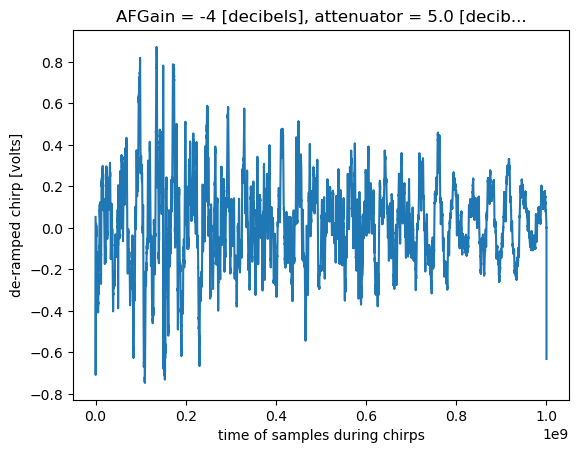

In [8]:
example_chirp = timeseries.isel(time=0,chirp_num=0).chirp
example_chirp.plot()

(array([  90.,  187.,  236.,  267.,  562., 1694., 2926., 4679., 5756.,
        6326., 6626., 4767., 2763., 1621.,  749.,  264.,  152.,  138.,
         142.,   56.]),
 array([-0.74672699, -0.66578674, -0.5848465 , -0.50390625, -0.422966  ,
        -0.34202576, -0.26108551, -0.18014526, -0.09920502, -0.01826477,
         0.06267548,  0.14361572,  0.22455597,  0.30549622,  0.38643646,
         0.46737671,  0.54831696,  0.6292572 ,  0.71019745,  0.7911377 ,
         0.87207794]),
 <BarContainer object of 20 artists>)

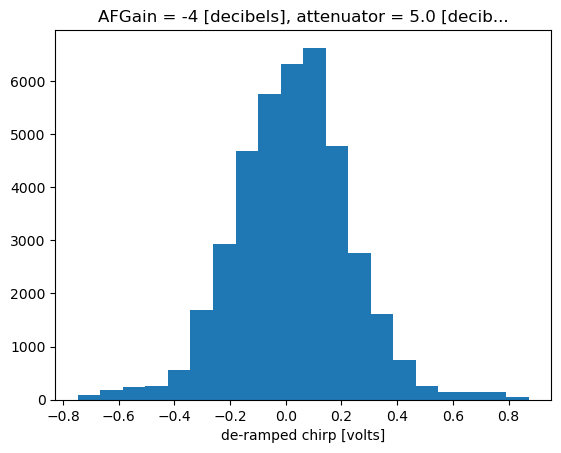

In [10]:
example_chirp.plot.hist(bins=20)

Next, the processing calls for some windowing to be done on this chirp (need theory here). Using a blackman window seems to be the default. Applying blackman window:

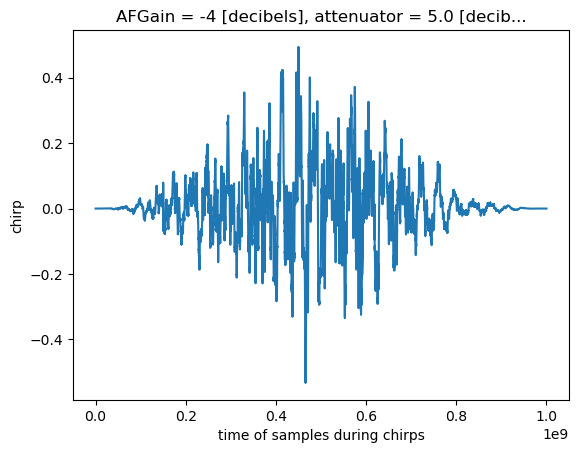

In [11]:
win_chirp = (example_chirp*np.blackman(len(example_chirp)))
win_chirp.plot()

After this windowing is completed, we rotate and pad.

80002


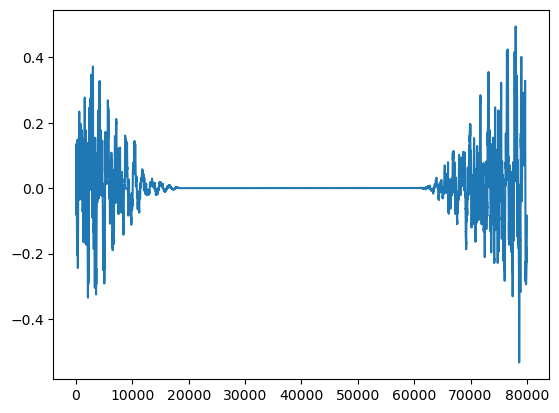

In [12]:
pad =2
Nt = len(win_chirp)
Nfft = math.floor(Nt*pad)
print(Nfft)
padchirp = np.zeros(Nfft)
padchirp[0:math.floor(Nt/2)] = win_chirp.data[math.floor(Nt/2):-1]
padchirp[-math.floor(Nt/2):] = win_chirp.data[0:math.floor(Nt/2)]
plt.plot(padchirp)

After this step, we take a fourier transform to get the shape of the range profile. We take the decibel value of the amplitude of the FFT result to get the profile shape that we will eventually plot.

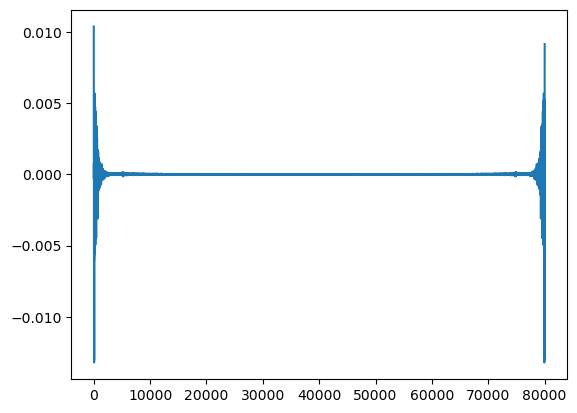

In [14]:
plt.plot(np.fft.fft(padchirp)/Nfft * math.sqrt(2*pad) )


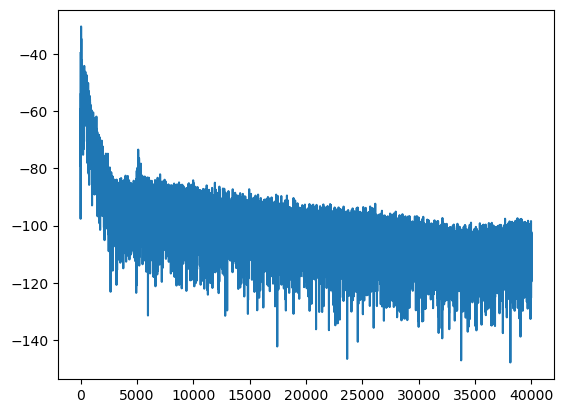

In [15]:
p = np.fft.fft(padchirp)/Nfft * math.sqrt(2*pad)
plt.plot(xa.dB(p[0:math.floor(Nfft/2)-1]))

From above, we can already see a peak (at 5000 - we haven't determined range bins yet) that likely indicates the bed reflector. So far in this procedure, we've influenced the results by picking the window and pad factor - two sensitivities that will need to be tested. Additionally, we are using the entirety of the chirp, which is yet another assumption that may be changed. Finally, there is the option to multiply this profile with a reference phase? (need to revisit theory). Doing this has some assumptions regarding the frequency range swept by the radar. 

In [18]:
profile = p[0:math.floor(Nfft/2)-1]
m = np.asarray([i for i in range(len(profile))])/pad
StartFreq = 2e8
StopFreq = 4e8
B = StopFreq - StartFreq
CentreFreq = B/2
K = 2e8 # I believe this is frequencies spanned over 1 second
phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
profile_ref = profile * np.exp(phiref*(-1j))

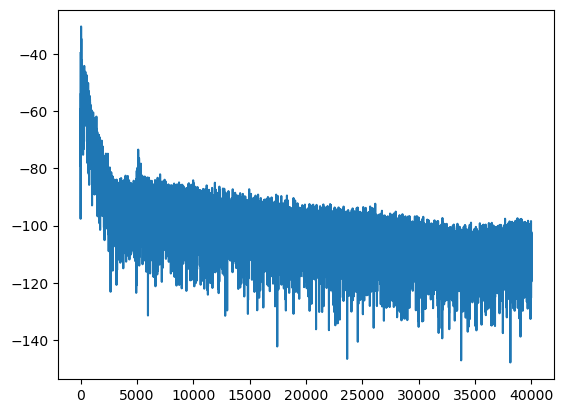

In [19]:
plt.plot(xa.dB(profile_ref))

This addtional step doesn't seem to change much.

Now, we move to determining the ranges associated with this profile. We first convert each bin from the FFT to a value in meters. This assumes that we know the speed of light in ice, which requires an assumption regarding the dielectric permittivity of ice. We assume it to be constant. Then, we multiply the bins by this array to get the range

In [21]:
c0 = 3e8 # speed of light in vaccuum
F0 = 2e8 # lower bound of window we want to look at in frequency space
F1 = 4e8 # upper bound of window we want to look at in frequency space
T0 = (F0-StartFreq)/K
T1 = (F1-StartFreq)/K
ER_ICE = 3.18
bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
profile_range = profile_range[0:math.floor(Nfft/2)-1]

Now we can plot the profiles with the correct ranges. Since we also know roughly where the bed is, we can window these values to focus on the ice.

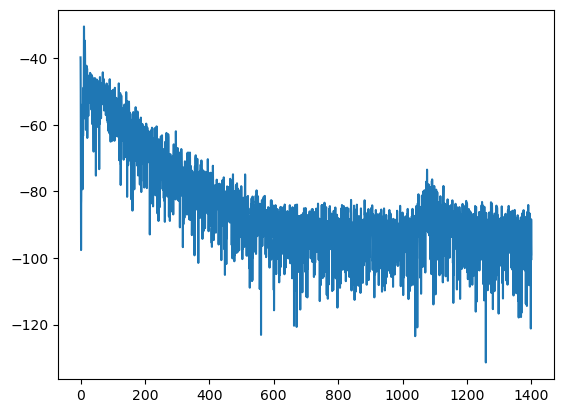

In [23]:
n = np.argmin(profile_range<=1400)
plt.plot(profile_range[:n],xa.dB(profile_ref[:n]))

To generate profiles with additional chirps, we can stack chirps on top of each other and use this exact same flow to generate a profile. Additionally, this creates the same result as calculating profiles for each chirp and then taking the mean. Plotting our stacked profile against the profile from the individual chirp from above, we see that we lower the noise floor by quite a bit. This introduces another degree of freedom, as the choice of which chirps to stack will influence the final profile.

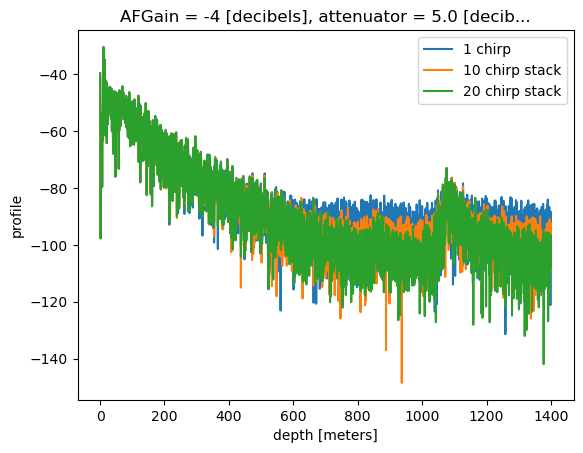

In [37]:
plt.plot(profile_range[:n],xa.dB(profile_ref[:n]),label='1 chirp')
xa.dB(timeseries.isel(time=0,chirp_num=range(0,10)).profile.mean(dim='chirp_num')).plot(label='10 chirp stack')
xa.dB(timeseries.isel(time=0).profile.mean(dim='chirp_num')).plot(label='20 chirp stack')

plt.legend()

## Part 2: Investigating the impact of "bad" data
We go through the exact same steps as before, except with a chirp from bursts that we suspect are clipped or oversaturated. The below 100 burst sequence shows a very poorly defined bed reflector plus striping that looks like some sort of aliasing

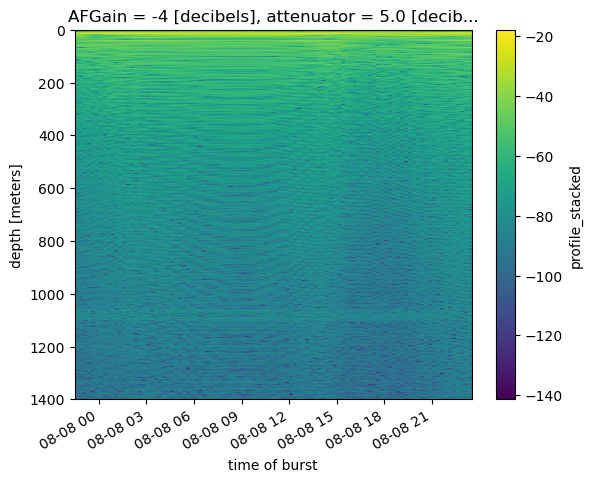

In [42]:
timeseries = ds_101.isel(attenuator_setting_pair = 0,time=range(7050,7150)).compute()
xa.dB(timeseries.profile_stacked).plot(x='time')
plt.gca().invert_yaxis()

Taking a chirp from this time, we see signs of a clipped signal, especially at the start of the burst

(array([3211.,  680.,  612.,  826., 1129., 1206., 2289., 2698., 3001.,
        3481., 3579., 3004., 2942., 2192., 1657., 2865., 1779.,  821.,
         557., 1472.]),
 array([-1.23157501, -1.10749817, -0.98342133, -0.85934448, -0.73526764,
        -0.6111908 , -0.48711395, -0.36303711, -0.23896027, -0.11488342,
         0.00919342,  0.13327026,  0.25734711,  0.38142395,  0.50550079,
         0.62957764,  0.75365448,  0.87773132,  1.00180817,  1.12588501,
         1.24996185]),
 <BarContainer object of 20 artists>)

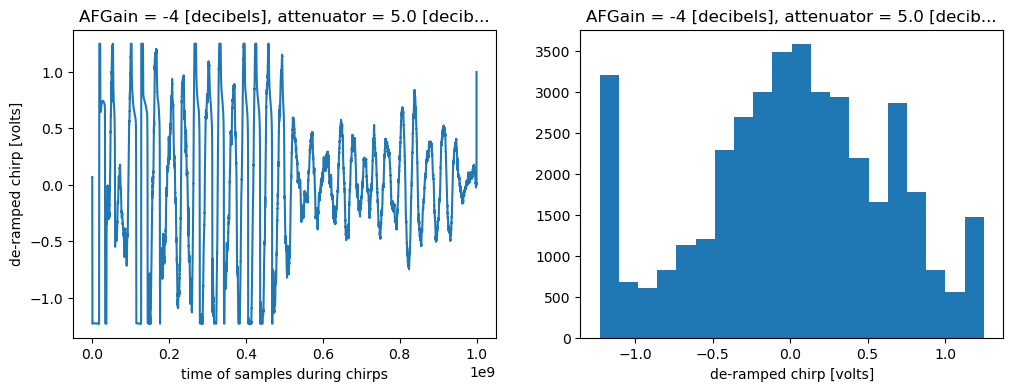

In [61]:
fig, axs = plt.subplots(nrows = 1, ncols = 2,figsize=(12,4))
example_chirp = timeseries.isel(time=12,chirp_num=0).chirp
example_chirp.plot(ax=axs[0])
example_chirp.plot.hist(bins=20,ax=axs[1])

If we try with the other attenuation settings, we see that there is no longer any clipping. 

(array([ 207.,  659.,  765., 1118., 1053.,  920., 1641., 2389., 3768.,
        4881., 5332., 4447., 3720., 2706., 3562., 1073.,  690.,  345.,
         525.,  200.]),
 array([-0.61069489, -0.54953766, -0.48838043, -0.42722321, -0.36606598,
        -0.30490875, -0.24375153, -0.1825943 , -0.12143707, -0.06027985,
         0.00087738,  0.06203461,  0.12319183,  0.18434906,  0.24550629,
         0.30666351,  0.36782074,  0.42897797,  0.49013519,  0.55129242,
         0.61244965]),
 <BarContainer object of 20 artists>)

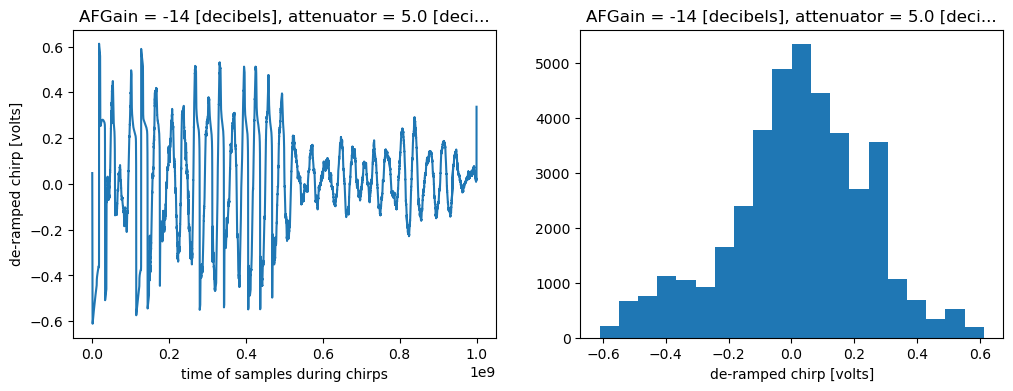

In [54]:
large_gain = (ds_101.isel(attenuator_setting_pair = 1,time=range(7050,7150))).isel(time=12,chirp_num=0).chirp
fig, axs = plt.subplots(nrows = 1, ncols = 2,figsize=(12,4))
large_gain.plot(ax=axs[0])
large_gain.plot.hist(bins=20,ax=axs[1])


Let's go through the profile calculation for the clipped chirp. It doesn't look great. Stacking doesn't help much either

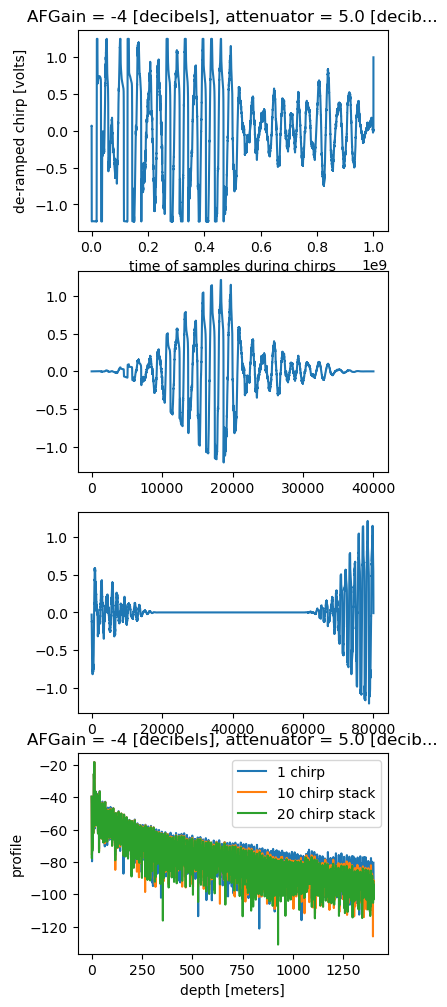

In [65]:
fig, axs = plt.subplots(nrows = 4, ncols = 1,figsize=(4,12))
example_chirp.plot(ax=axs[0])
win_chirp = (example_chirp*np.blackman(len(example_chirp)))
axs[1].plot(win_chirp)

pad = 2
Nt = len(win_chirp)
Nfft = math.floor(Nt*pad)
padchirp = np.zeros(Nfft)
padchirp[0:math.floor(Nt/2)] = win_chirp.data[math.floor(Nt/2):-1]
padchirp[-math.floor(Nt/2):] = win_chirp.data[0:math.floor(Nt/2)]
axs[2].plot(padchirp)
p = np.fft.fft(padchirp)/Nfft * math.sqrt(2*pad)
profile = p[0:math.floor(Nfft/2)-1]
m = np.asarray([i for i in range(len(profile))])/pad
phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
profile_ref = profile * np.exp(phiref*(-1j))
profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
profile_range = profile_range[0:math.floor(Nfft/2)-1]
n = np.argmin(profile_range<=1400)
axs[3].plot(profile_range[:n],xa.dB(profile_ref[:n]),label='1 chirp')
xa.dB(timeseries.isel(time=12,chirp_num=range(0,10)).profile.mean(dim='chirp_num')).plot(ax=axs[3],label='10 chirp stack')
xa.dB(timeseries.isel(time=12).profile.mean(dim='chirp_num')).plot(ax=axs[3],label='20 chirp stack')

plt.legend()

What is a potential point of concern is that even though the setting with a stronger gain doesn't appear to be clipped upon examination, it still doesn't help with making the signal any better, shown below.

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


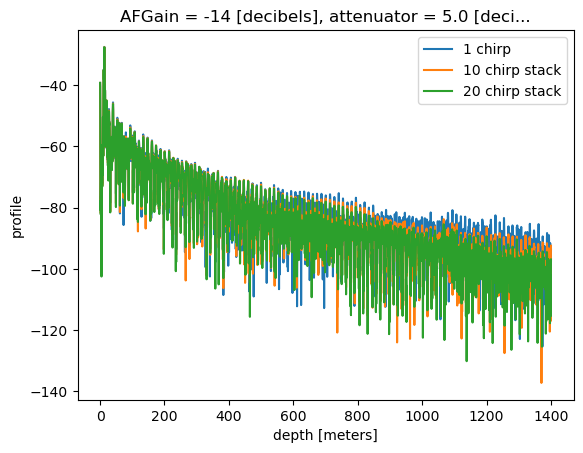

In [57]:
win_chirp = (large_gain*np.blackman(len(large_gain)))
pad =2
Nt = len(win_chirp)
Nfft = math.floor(Nt*pad)
padchirp = np.zeros(Nfft)
padchirp[0:math.floor(Nt/2)] = win_chirp.data[math.floor(Nt/2):-1]
padchirp[-math.floor(Nt/2):] = win_chirp.data[0:math.floor(Nt/2)]
p = np.fft.fft(padchirp)/Nfft * math.sqrt(2*pad)
profile = p[0:math.floor(Nfft/2)-1]
m = np.asarray([i for i in range(len(profile))])/pad
phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
profile_ref = profile * np.exp(phiref*(-1j))
profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
profile_range = profile_range[0:math.floor(Nfft/2)-1]
n = np.argmin(profile_range<=1400)
plt.plot(profile_range[:n],xa.dB(profile_ref[:n]),label='1 chirp')
xa.dB((ds_101.isel(attenuator_setting_pair = 1,time=range(7050,7150))).isel(time=12,chirp_num=range(0,10)).profile.mean(dim='chirp_num')).plot(label='10 chirp stack')
xa.dB((ds_101.isel(attenuator_setting_pair = 1,time=range(7050,7150))).isel(time=12).profile.mean(dim='chirp_num')).plot(label='20 chirp stack')

plt.legend()

## Part 3: Sensitivity tests on profile formation
Now, we test how sensitive these profiles are to the input settings. Let's first define a function that generates relevant plots along the calculation steps given a set of parameter inputs.